# Exploring San Francisco Bikeshare Data

This challenge uses an Francisco's bikeshare trips from BigQuery Public datasets S. Here are the descriptions of some of the relevant fields:

|Field name|Type|Mode|Description|
|:---|:---:|:---:|:---|
|trip_id|INTEGER|REQUIRED|Numeric ID of bike trip|
|duration_sec|INTEGER|NULLABLE|Time of trip in seconds|
|start_date|TIMESTAMP|NULLABLE|Start date of trip with date and time, in PST|
|start_station_name|STRING|NULLABLE|Station name of start station|
|start_station_id|INTEGER|NULLABLE|Numeric reference for start station|
|end_date|TIMESTAMP|NULLABLE|End date of trip with date and time, in PST|
|end_station_name|STRING|NULLABLE|Station name for end station|
|end_station_id|INTEGER|NULLABLE|Numeric reference for end station|
|bike_number|INTEGER|NULLABLE|ID of bike used|
|zip_code|STRING|NULLABLE|Home zip code of subscriber|
|subscriber_type|STRING|NULLABLE|Subscriber = annual or 30-day member; Customer = 24-hour or 3-day member|

For this challenge, we seek to demonstrate doing queries, applying some statistical metrics and implementing machine learning models to extract insights from the dataset. In particular, we wish to accomplish these items.

## Part 1
1. `[BigQuery]` [Daily number of rides for January 2016](#part1_1)
2. `[BigQuery]` [Weekly number of rides for all time](#part1_2)
3. `[BigQuery]` [Monthly number of rides for all time](#part1_3)
4. `[BigQuery]` [Histogram of ride durations across all time](#part1_4)
5. `[BigQuery]` [Monthly median ride duration across all time](#part1_5)
6. `[BigQuery]` [Fraction of weekly “Subscriber” subscriber_type rentals across all time](#part1_6)

## Part 2
1. `[BigQuery]` `[Stats]` [Are the Subscriber and Customer subscriber_types different in any statistically significant way?](#part2_1)

## Part 3
1. `[Machine Learning]` [Build a classifier to predict if a subscriber_type is a Subscriber or Customer. How well does it perform?](#part3_1)

### Importing libraries to directly query from BigQuery Public Data

In [100]:
import pandas as pd
import pandas_gbq

from google.cloud import bigquery
%load_ext google.cloud.bigquery

pandas_gbq.context.project = 'bigquery-public-data'
pandas_gbq.context.dialect = 'standard'

import warnings
warnings.filterwarnings('ignore')

import altair as alt
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import datetime
from io import StringIO

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


### Part 1.1 Daily number of rides for January 2016 <a id='part1_1'></a>

There is a need to clarify the definition of the `number of rides`. Quering count vs distinct count and aggregating per day results to conflicting values for January 12.

In [2]:
%%bigquery
SELECT 
    EXTRACT(DATE FROM start_date) as Day, COUNT(trip_id) as Number_of_Rides, 
    COUNT(DISTINCT trip_id) as Number_of_Rides_Distinct
FROM 
    `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` 
WHERE 
    EXTRACT(YEAR FROM start_date) = 2016 and 
    EXTRACT(MONTH FROM start_date) = 1
GROUP BY 
    day
ORDER BY 
    day

Downloading: 100%|██████████| 31/31 [00:02<00:00, 11.16rows/s]


,Day,Number_of_Rides,Number_of_Rides_Distinct
0,2016-01-01,98,98
1,2016-01-02,154,154
2,2016-01-03,135,135
3,2016-01-04,765,765
4,2016-01-05,632,632
5,2016-01-06,562,562
6,2016-01-07,978,978
7,2016-01-08,909,909
8,2016-01-09,132,132
9,2016-01-10,133,133


If we look at this particular date and filter by trip counts greater than 1,

In [5]:
%%bigquery
SELECT 
    * 
FROM 
    (SELECT 
        trip_id, count(trip_id) as counter
    FROM
         `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
    WHERE 
         EXTRACT(Date FROM start_date) = '2016-01-12'
    GROUP BY 
         trip_id
    ORDER BY 
         counter)
WHERE 
    counter > 1

Downloading: 100%|██████████| 1/1 [00:03<00:00,  3.02s/rows]


,trip_id,counter
0,50320160112170300,2


and investigate on this particular id,

In [7]:
%%bigquery
SELECT 
    *
FROM 
    `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` 
WHERE 
    EXTRACT(Date FROM start_date) = '2016-01-12' and 
    trip_id = '50320160112170300'

Downloading: 100%|██████████| 2/2 [00:03<00:00,  1.64s/rows]


,trip_id,duration_sec,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_number,zip_code,...,c_subscription_type,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,member_birth_year,member_gender,bike_share_for_all_trip,start_station_geom,end_station_geom
0,50320160112170300,244,2016-01-12 17:03:00+00:00,2nd at Folsom,62,2016-01-12 17:07:00+00:00,Spear at Folsom,49,503,94105,...,None,NaN,NaN,NaN,NaN,NaN,None,None,None,None
1,50320160112170300,243,2016-01-12 17:03:00+00:00,2nd at Folsom,62,2016-01-12 17:08:00+00:00,Spear at Folsom,49,503,94105,...,None,NaN,NaN,NaN,NaN,NaN,None,None,None,None


It looks like the ride is counted double for that day, meaning same start time, location and 1 minute difference in end time. 

So we can safely assume that it is redundunt and use COUNT DISTINCT instead of only COUNT.

In [8]:
%%bigquery df_rides_in_jan_2016
SELECT 
    EXTRACT(DATE FROM start_date) as Day, 
    COUNT(DISTINCT trip_id) as Number_of_Rides
FROM 
    `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` 
WHERE 
    EXTRACT(YEAR FROM start_date) = 2016 and 
    EXTRACT(MONTH FROM start_date) = 1
GROUP BY 
    day
ORDER BY 
    day

Downloading: 100%|██████████| 31/31 [00:03<00:00,  9.00rows/s]


In [9]:
df_rides_in_jan_2016['Day'] = pd.to_datetime(df_rides_in_jan_2016['Day'])

In [14]:
alt.Chart(df_rides_in_jan_2016).mark_bar().encode(
    x = alt.X('date(Day):O', title='January 2016',axis=alt.Axis(labelAngle=0)),
    y = alt.Y('Number_of_Rides', title='Number of Unique Rides')).properties(
    title='January 2016 - Number of Unique Rides per Day')

alt.Chart(...)

Since this is a timeseries data, we can visually see the trend (cyclical). The lows on the histogram are weekends which tell us that people are mostly using the bikes for commute.

### Part 1.2 Weekly number of rides for all time <a id='part1_2'></a>

In [15]:
%%bigquery df_number_of_rides_per_week
SELECT 
    CONCAT(EXTRACT(YEAR FROM start_date), '-', EXTRACT(WEEK FROM start_date)) as week, 
    COUNT(trip_id) as number_of_rides 
FROM 
    `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
GROUP BY 
    week
ORDER BY 
    min(start_date)

Downloading: 100%|██████████| 207/207 [00:03<00:00, 61.38rows/s]


In [21]:
df_number_of_rides_per_week['week'] = df_number_of_rides_per_week['week'].astype(str)

interval = alt.selection_interval(encodings=['x'])

base = alt.Chart(df_number_of_rides_per_week).mark_rule(size=2).encode(
    x = alt.X('week:O', title='Week Number'),
    y = alt.Y('number_of_rides', title='Number of Rides')).properties(
    title='Number of Rides per Week')

chart = base.encode(
    x=alt.X('week:O', title='Week Number', scale=alt.Scale(domain=interval.ref()))
).properties(
    width=800,
    height=300
)

view = base.add_selection(
    interval
).properties(
    width=800,
    height=50,
)

chart & view

alt.VConcatChart(...)

This plot is a has a slider subplot at the bottom to easily drill through granular patterns. We see that a rapid increase of bike use occured starting from 27th week of 2017 with a sudden dip on the 53rd week of 2017.

### Part 1.3 Monthly number of rides for all time¶<a id='part1_3'></a>

In [17]:
%%bigquery df_number_of_rides_per_month
SELECT 
    CONCAT(EXTRACT(YEAR FROM start_date), '-', EXTRACT(MONTH FROM start_date)) as month_, 
    COUNT(trip_id) as number_of_rides 
FROM 
    `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
GROUP BY 
    month_
ORDER BY 
    min(start_date)

Downloading: 100%|██████████| 48/48 [00:02<00:00, 18.69rows/s]


In [18]:
alt.Chart(df_number_of_rides_per_month).mark_bar().encode(
    x = alt.X('month_:O', title='Year Month'),
    y = alt.Y('number_of_rides', title='Number of Rides')).properties(
    title='Number of Rides per Month')

alt.Chart(...)

We observe here the same trends from Part 1.2.

### Part 1.4 Histogram of ride durations across all time <a id='part1_4'></a>

In [22]:
%%bigquery df_ride_durations
SELECT 
    duration_sec
FROM 
    `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`

Downloading: 100%|██████████| 1947419/1947419 [00:06<00:00, 310848.47rows/s]


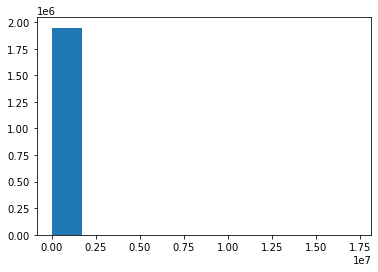

In [29]:
plt.hist(df_ride_durations['duration_sec'])
plt.show()

Looks like the data is sparse. Let's look at central measures.

In [30]:
df_ride_durations.describe()

,duration_sec
count,1.947419e+06
mean,1.007971e+03
std,1.326852e+04
min,6.000000e+01
25%,3.570000e+02
50%,5.430000e+02
75%,8.170000e+02
max,1.727040e+07


<AxesSubplot:>

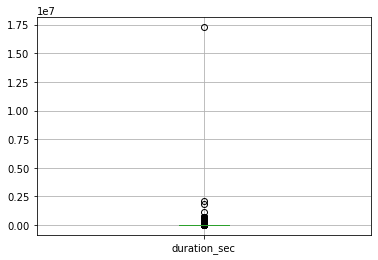

In [31]:
df_ride_durations.boxplot()

<AxesSubplot:>

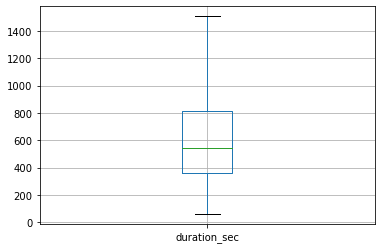

In [32]:
df_ride_durations.boxplot(showfliers=False)

There is an extreme outlier for a bike duration: `1.727040e+07 seconds` or about `6 months`! There can be multiple explanations for this. Maybe thier system got rigged or they have a data input problem. For this demo, I will not deal with "cleaning" the data but just plot it with logarithmic scales (since values are far apart).

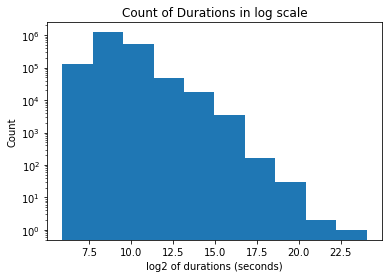

In [38]:
plt.hist(np.log2(df_ride_durations['duration_sec']), log=True)
plt.ylabel('Count')
plt.xlabel('log2 of durations (seconds)')
plt.title('Count of Durations in log scale')
plt.show()

### Part 1.5 Monthly median ride duration across all time <a id='part1_5'></a>

In [39]:
%%bigquery df_ride_durations_median_per_month
SELECT month_, ANY_VALUE(median) as median_
FROM
(SELECT
    start_date,
    month_,
    PERCENTILE_CONT(duration_sec, 0.5) OVER(PARTITION BY month_) AS median,
FROM
(SELECT
    start_date,
    CONCAT(EXTRACT(YEAR FROM start_date), '-', EXTRACT(MONTH FROM start_date)) as month_,
    duration_sec
FROM 
    `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`))
GROUP BY month_
ORDER BY min(start_date)

Downloading: 100%|██████████| 48/48 [00:03<00:00, 14.51rows/s]


In [40]:
df_ride_durations_median_per_month.head()

,month_,median_
0,2013-8,813.0
1,2013-9,634.0
2,2013-10,537.0
3,2013-11,525.0
4,2013-12,497.0


Let's verify the median value for `2013-8` using numpy.

In [41]:
%%bigquery df_median_spot_check
SELECT 
    duration_sec
FROM 
    `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` 
WHERE 
    EXTRACT(YEAR FROM start_date) = 2013 and 
    EXTRACT(MONTH FROM start_date) = 8

Downloading: 100%|██████████| 2102/2102 [00:03<00:00, 642.35rows/s]


In [42]:
np.median(df_median_spot_check['duration_sec'])

813.0

We verify that the values are correct so we can proceed in visualizing it.

In [43]:
alt.Chart(df_ride_durations_median_per_month).mark_bar().encode(
    x = alt.X('month_:O', title='Year Month'),
    y = alt.Y('median_', title='Median')).properties(
    title='Median Duration of Rides per Month (sec)')

alt.Chart(...)

Since the data is aggregated per month, we see that generally the distribution is uniform as what is inherent to bike ride durations.

### Part 1.6 Fraction of weekly “Subscriber” subscriber_type rentals across all time <a id='part1_6'></a>

In [45]:
%%bigquery
SELECT week, CAST(subscriber as DECIMAL)/(subscriber+customer) as subs
FROM
(SELECT
    CONCAT(EXTRACT(YEAR FROM start_date), '-', EXTRACT(WEEK FROM start_date)) as week,
    SUM(CASE WHEN subscriber_type = 'Subscriber' THEN 1 ELSE 0 END) AS subscriber,
    SUM(CASE WHEN subscriber_type = 'Customer' THEN 1 ELSE 0 END) AS customer,
FROM
  `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
GROUP BY 
    week
ORDER BY
    min(start_date))

Downloading: 100%|██████████| 207/207 [00:03<00:00, 62.13rows/s]


,week,subs
0,2013-34,0.441960038
1,2013-35,0.425777229
2,2013-36,0.607495741
3,2013-37,0.690487610
4,2013-38,0.696660757
...,...,...
202,2018-13,0.852156135
203,2018-14,0.841167836
204,2018-15,0.842545142
205,2018-16,0.837014407


Let's verify the subscriber ration for week `2013-34`.

In [46]:
%%bigquery df_median_sub_ratio_check
SELECT 
    CONCAT(EXTRACT(YEAR FROM start_date), '-', EXTRACT(WEEK FROM start_date)) as week,
    subscriber_type
FROM 
    `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` 
WHERE 
    EXTRACT(YEAR FROM start_date) = 2013 and 
    EXTRACT(WEEK FROM start_date) = 34

Downloading: 100%|██████████| 2102/2102 [00:03<00:00, 546.32rows/s]


In [47]:
sub = len(df_median_sub_ratio_check[df_median_sub_ratio_check['subscriber_type'] == 'Subscriber'])
cust = len(df_median_sub_ratio_check[df_median_sub_ratio_check['subscriber_type'] == 'Customer'])
sub_ratio = sub/(sub+cust)

In [48]:
sub_ratio

0.4419600380589914

We can confirm that the calculations are correct so we can go ahead to plotting it.

In [51]:
%%bigquery df_weekly_subs_ratio
SELECT week, CAST(subscriber as DECIMAL)/(subscriber+customer) as subs
FROM
(SELECT
    CONCAT(EXTRACT(YEAR FROM start_date), '-', EXTRACT(WEEK FROM start_date)) as week,
    SUM(CASE WHEN subscriber_type = 'Subscriber' THEN 1 ELSE 0 END) AS subscriber,
    SUM(CASE WHEN subscriber_type = 'Customer' THEN 1 ELSE 0 END) AS customer,
FROM
  `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
GROUP BY 
    week
ORDER BY
    min(start_date))

Downloading: 100%|██████████| 207/207 [00:03<00:00, 61.10rows/s]


In [56]:
df_weekly_subs_ratio['week'] = df_weekly_subs_ratio['week'].astype(str)
df_weekly_subs_ratio['subs'] = df_weekly_subs_ratio['subs'].astype(float)

interval = alt.selection_interval(encodings=['x'])

base = alt.Chart(df_weekly_subs_ratio).mark_bar().encode(
    x = alt.X('week:O', title='Year Week'),
    y = alt.Y('subs', title='Subscriber Ratio')).properties(
    title='Ratio of Subscribers across all Week')

chart = base.encode(
    x=alt.X('week:O', title='Year Week', scale=alt.Scale(domain=interval.ref()))
).properties(
    width=800,
    height=300
)

view = base.add_selection(
    interval
).properties(
    width=800,
    height=50,
)

chart & view

alt.VConcatChart(...)

### Part 2.1 Are the Subscriber and Customer subscriber_types different in any statistically significant way? <a id='part2_1'></a>

There are many ways to test statistical difference between two sets e.g. t-test, ANOVA. For this exercise, I will use simple t-test.

Let's define our null hypothesis as A=B where A describes the subscribers while B the customers. We can exhaust different features in the dataset to consider as our set but let's trim it down to the following metrics:

- total count per day
- average duration per day

- total count per week
- average duration per week

- average duration per month
- total count per month

We will use alpha as 0.05 as our threshold.

### total count per day

In [58]:
%%bigquery df_total_count_per_day_test
SELECT 
    EXTRACT(DATE FROM start_date) as day,
    SUM(CASE WHEN subscriber_type = 'Subscriber' THEN 1 ELSE 0 END) AS subscriber,
    SUM(CASE WHEN subscriber_type = 'Customer' THEN 1 ELSE 0 END) AS customer,
FROM 
    `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
GROUP BY 
    day

Downloading: 100%|██████████| 1406/1406 [00:03<00:00, 437.25rows/s]


In [60]:
A_total_day = df_total_count_per_day_test['subscriber'].values.tolist()
B_total_day = df_total_count_per_day_test['customer'].values.tolist()

In [61]:
t_check=stats.ttest_ind(A_total_day,B_total_day)
alpha=0.05
if(t_check[1]<alpha):
    print('A different from B')

A different from B


### average duration per day

In [63]:
%%bigquery df_mean_duration_per_day_test
SELECT 
    EXTRACT(DATE FROM start_date) as day,
    AVG(CASE WHEN subscriber_type = 'Subscriber' THEN duration_sec END) AS subscriber,
    AVG(CASE WHEN subscriber_type = 'Customer' THEN duration_sec END) AS customer,
FROM 
    `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
GROUP BY 
    day
ORDER BY day

Downloading: 100%|██████████| 1406/1406 [00:03<00:00, 425.35rows/s]


In [64]:
A_mean_day = df_mean_duration_per_day_test['subscriber'].values.tolist()
B_mean_day = df_mean_duration_per_day_test['customer'].values.tolist()

In [65]:
t_check=stats.ttest_ind(A_mean_day ,B_mean_day )
alpha=0.05
if(t_check[1]<alpha):
    print('A different from B')

A different from B


### total count per week

In [66]:
%%bigquery df_total_count_per_week_test
SELECT 
    CONCAT(EXTRACT(YEAR FROM start_date), '-', EXTRACT(WEEK FROM start_date)) as week, 
    SUM(CASE WHEN subscriber_type = 'Subscriber' THEN 1 ELSE 0 END) AS subscriber,
    SUM(CASE WHEN subscriber_type = 'Customer' THEN 1 ELSE 0 END) AS customer,
FROM 
    `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
GROUP BY 
    week

Downloading: 100%|██████████| 207/207 [00:03<00:00, 63.44rows/s]


In [67]:
A_total_week = df_total_count_per_week_test['subscriber'].values.tolist()
B_total_week = df_total_count_per_week_test['customer'].values.tolist()

In [68]:
t_check=stats.ttest_ind(A_total_week,B_total_week)
alpha=0.05
if(t_check[1]<alpha):
    print('A different from B')

A different from B


### total duration per week

In [69]:
%%bigquery df_mean_duration_per_week_test
SELECT 
    CONCAT(EXTRACT(YEAR FROM start_date), '-', EXTRACT(WEEK FROM start_date)) as week, 
    AVG(CASE WHEN subscriber_type = 'Subscriber' THEN duration_sec END) AS subscriber,
    AVG(CASE WHEN subscriber_type = 'Customer' THEN duration_sec END) AS customer,
FROM 
    `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
GROUP BY 
    week
ORDER BY week

Downloading: 100%|██████████| 207/207 [00:03<00:00, 62.15rows/s]


In [70]:
A_mean_week = df_mean_duration_per_week_test['subscriber'].values.tolist()
B_mean_week = df_mean_duration_per_week_test['customer'].values.tolist()

In [71]:
t_check=stats.ttest_ind(A_mean_week,B_mean_week)
alpha=0.05
if(t_check[1]<alpha):
    print('A different from B')

A different from B


### total count per month

In [72]:
%%bigquery df_total_count_per_month_test
SELECT 
    CONCAT(EXTRACT(YEAR FROM start_date), '-', EXTRACT(MONTH FROM start_date)) as month_, 
    SUM(CASE WHEN subscriber_type = 'Subscriber' THEN 1 ELSE 0 END) AS subscriber,
    SUM(CASE WHEN subscriber_type = 'Customer' THEN 1 ELSE 0 END) AS customer,
FROM 
    `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
GROUP BY 
    month_

Downloading: 100%|██████████| 48/48 [00:03<00:00, 14.71rows/s]


In [73]:
A_total_month = df_total_count_per_month_test['subscriber'].values.tolist()
B_total_month = df_total_count_per_month_test['customer'].values.tolist()

In [74]:
t_check=stats.ttest_ind(A_total_month,B_total_month)
alpha=0.05
if(t_check[1]<alpha):
    print('A different from B')

A different from B


### average duration per month

In [75]:
%%bigquery df_mean_duration_per_month_test
SELECT 
    CONCAT(EXTRACT(YEAR FROM start_date), '-', EXTRACT(MONTH FROM start_date)) as month_,
    AVG(CASE WHEN subscriber_type = 'Subscriber' THEN duration_sec END) AS subscriber,
    AVG(CASE WHEN subscriber_type = 'Customer' THEN duration_sec END) AS customer,
FROM 
    `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
GROUP BY 
    month_
ORDER BY month_

Downloading: 100%|██████████| 48/48 [00:03<00:00, 12.14rows/s]


In [76]:
A_mean_month = df_mean_duration_per_month_test['subscriber'].values.tolist()
B_mean_month = df_mean_duration_per_month_test['customer'].values.tolist()

In [77]:
t_check=stats.ttest_ind(A_mean_month,B_mean_month)
alpha=0.05
if(t_check[1]<alpha):
    print('A different from B')

A different from B


By just looking at duration and count for different temporal aggregates we see that there is a statistical difference between Subscribers and Customers.

This can warrant a use case in a classification problem.

### EXTRA BONUS FOR BIKE PATTERN

In [86]:
%%bigquery df_bonus_1
SELECT 
    EXTRACT(DATE FROM start_date) as Day, COUNT(trip_id) as Number_of_Rides, 
FROM 
    `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` 
WHERE 
    EXTRACT(YEAR FROM start_date) = 2016
GROUP BY 
    day
ORDER BY 
    day

Downloading: 100%|██████████| 244/244 [00:03<00:00, 79.39rows/s]


In [87]:
df_bonus_1['Day'] = pd.to_datetime(df_bonus_1['Day'])
alt.Chart(df_bonus_1).mark_rect().encode(
    alt.X('date(Day):O', title='day'),
    alt.Y('month(Day):O', title='month'),
    color='Number_of_Rides:Q'
).properties(
    title="2016 Bike Counts"
)

alt.Chart(...)

In [97]:
%%bigquery df_bonus_2
SELECT 
    start_date as Day
FROM 
    `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` 
WHERE 
    EXTRACT(YEAR FROM start_date) = 2016 and
    EXTRACT(MONTH FROM start_date) = 1 and 
    EXTRACT(DAY FROM start_date) IN (1,2,3,4,5,6,7,8,9)

Downloading: 100%|██████████| 4365/4365 [00:03<00:00, 1311.36rows/s]


In [98]:
df_bonus_2['Day'] = pd.to_datetime(df_bonus_2['Day'])
alt.Chart(df_bonus_2).mark_rect().encode(
    alt.X('hoursminutes(Day):O', title='hour of day'),
    alt.Y('monthdate(Day):O', title='date'),
    alt.Color('count()', title='Number of Rides')
)

alt.Chart(...)

### Part 3.1 Build a classifier to predict if a subscriber_type is a Subscriber or Customer. How well does it perform? <a id='part3_1'></a>

### Fetching data from source

In [124]:
%%bigquery df_full
SELECT 
    *
FROM 
    `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`

Downloading: 100%|██████████| 1947419/1947419 [00:52<00:00, 36768.43rows/s]


### Feature Engineering (encoding, balancing, splitting)

In [125]:
df_model = df_full[['trip_id','duration_sec','start_station_id',
                    'end_station_id','bike_number','subscriber_type','member_birth_year',
                    'member_gender','bike_share_for_all_trip']]

df_model = df_model.dropna()

# Let's do some encoding
df_model['category_id'] = df_model['subscriber_type'].factorize()[0]
df_model['member_gender'] = df_model['member_gender'].factorize()[0]
df_model['bike_share_for_all_trip'] = df_model['bike_share_for_all_trip'].factorize()[0]

category_id_df = df_model[['subscriber_type', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'subscriber_type']].values)

In [126]:
df_model.head()

,trip_id,duration_sec,start_station_id,end_station_id,bike_number,subscriber_type,member_birth_year,member_gender,bike_share_for_all_trip,category_id
0,18342018013122532700,592,202,195,1834,Customer,1978.0,0,0,0
1,25082018013122380400,209,160,230,2508,Subscriber,1986.0,0,0,1
2,32672018013122023800,398,176,173,3267,Subscriber,1966.0,0,0,1
3,17092018013121464400,205,279,275,1709,Subscriber,1993.0,0,0,1
4,16262018013119345100,360,280,311,1626,Subscriber,1994.0,0,1,1


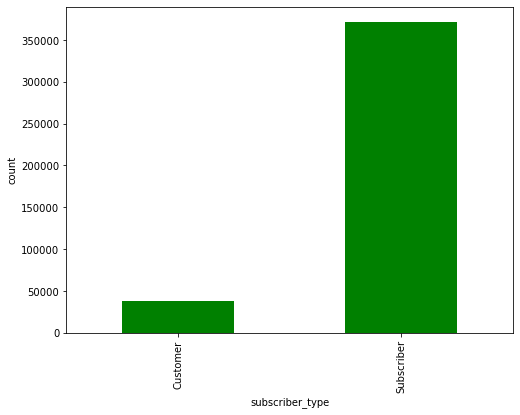

In [127]:
fig = plt.figure(figsize=(8,6))
df_model.groupby('subscriber_type').trip_id.count().plot.bar(ylim=0,color='g')
plt.ylabel('count')
plt.show()

In [128]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df_model[df_model['category_id']==1]
df_minority = df_model[df_model['category_id']==0]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    
                                 n_samples=len(df_minority))

df_model_1 = pd.concat([df_majority_downsampled, df_minority])

In [151]:
len(df_minority)

38436

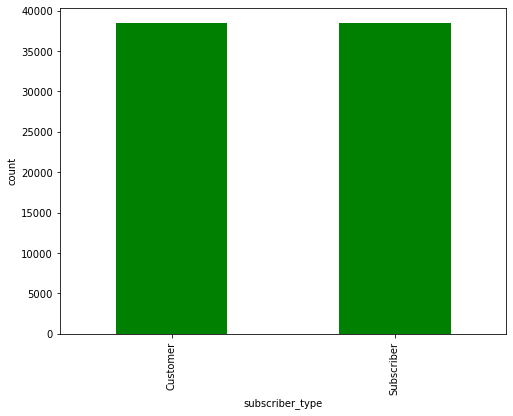

In [129]:
fig = plt.figure(figsize=(8,6))
df_model_1.groupby('subscriber_type').trip_id.count().plot.bar(ylim=0,color='g')
plt.ylabel('count')
plt.show()

In [152]:
X = df_model_1[['duration_sec','start_station_id',
                    'end_station_id','bike_number','member_birth_year',
                    'member_gender','bike_share_for_all_trip']]
y = df_model_1[['category_id']]

### Feature Importance

Text(0.5, 0, 'Random Forest Feature Importance')

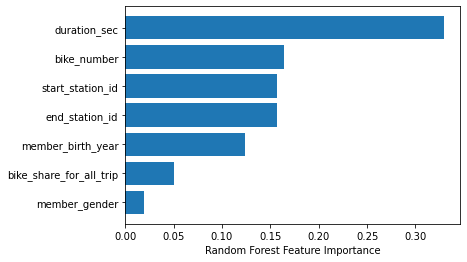

In [146]:
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

sorted_idx = rf.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Model Selection and Training

In [153]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier

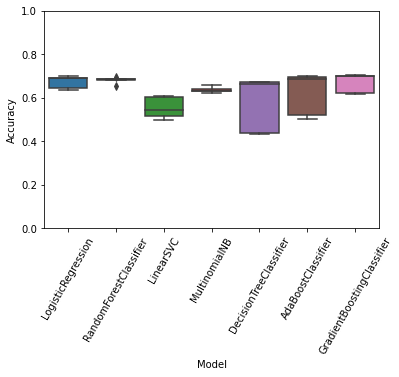

In [154]:
models = [
    LogisticRegression(random_state=0),
    RandomForestClassifier(n_estimators=100, max_depth=2, random_state=11),
    LinearSVC(),
    MultinomialNB(),
    DecisionTreeClassifier(),
    AdaBoostClassifier(n_estimators=20),
    GradientBoostingClassifier(n_estimators=20)
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X, y, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
g = sns.boxplot(x='model_name', y='accuracy', data=cv_df)

g.set_xticklabels(g.get_xticklabels(),rotation=60)
#sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=5, linewidth=1)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()

In [156]:
cv_df.groupby('model_name').accuracy.mean()

model_name
AdaBoostClassifier            0.622149
DecisionTreeClassifier        0.577087
GradientBoostingClassifier    0.669372
LinearSVC                     0.554570
LogisticRegression            0.673665
MultinomialNB                 0.638334
RandomForestClassifier        0.682095
Name: accuracy, dtype: float64

### Best Model

In [157]:
model = LogisticRegression()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, df_model_1.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

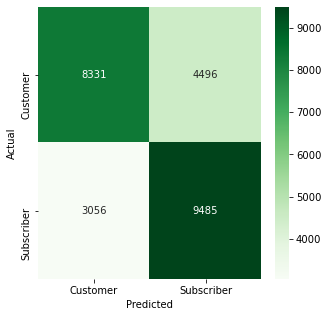

In [158]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, cmap="Greens", annot=True, fmt='d', 
            xticklabels=category_id_df.subscriber_type.values, 
            yticklabels=category_id_df.subscriber_type.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Comparing to XGBoost

In [141]:
import xgboost as xgb

D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'multi:softprob',  
    'num_class': 6} 

steps = 500
model = xgb.train(param, D_train, steps)

from sklearn.metrics import precision_score, recall_score, accuracy_score

preds = model.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(y_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(y_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_test, best_preds)))

[01:24:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Precision = 0.7428442506162714
Recall = 0.7424590292309301
Accuracy = 0.7421948912015137


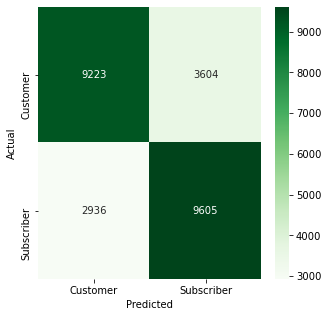

In [142]:
conf_mat = confusion_matrix(y_test, best_preds)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, cmap="Greens", annot=True, fmt='d', 
            xticklabels=category_id_df.subscriber_type.values, 
            yticklabels=category_id_df.subscriber_type.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Recommendations

To improve model performance the following operations can be considered:
1. consider grid search for hyperparameter tuning
2. consider standardizing the training dataset
3. consider combining both upsampling and downsampling to balance data
4. consider reducing feature dimensions via PCA